# [프로젝트] 복잡한 자연어 쿼리를 처리하는 Text-to-SQL   

Text-to-SQL 문제는 LLM의 대표적인 활용 분야 중 하나입니다.   
그러나, 쿼리가 복잡해지거나 단계적 작업을 수행해야 하는 경우에는 해결이 어려울 수 있는데요.   

복잡한 쿼리를 분해하거나 순차적으로 처리하도록 개선해 보겠습니다.


![Image](https://github.com/user-attachments/assets/0c69a680-a5e9-4863-91d4-e7be9eed3614)

In [ ]:
!pip install  langgraph langchain langchain_google_genai google_generativeai langchain_community python-dotenv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


이번 실습에서는 다음의 DB를 사용합니다.   

easy_sql.db : 도서관 DB  
intermediate_sql.db : 병원 DB   
hard_sql.db : 대학교 DB


In [ ]:
import zipfile

with zipfile.ZipFile('sql.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os
from typing import Dict, List, Any, Optional, Literal, TypedDict, Annotated
from datetime import datetime
from enum import Enum
from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel, Field
import sqlite3
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.utilities import SQLDatabase
import google.generativeai as genai
from dotenv import load_dotenv
from langgraph.graph.message import add_messages


# 환경 변수 로드
load_dotenv()


os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.5)


In [ ]:
# 상태 클래스 정의 (TypedDict 사용)
class State(TypedDict):
    """대화 상태를 추적하는 클래스"""
    messages: Annotated[list, add_messages]  # 메시지 목록
    current_query: str  # 현재 실행할 쿼리
    query_results: list[dict]  # 쿼리 실행 결과 목록
    db_path: str  # 데이터베이스 경로
    query_history: list[str]  # 쿼리 실행 기록
    error_message: str  # 오류 메시지
    final_analysis: str  # 최종 분석 결과
    next_step: str  # 다음 단계
    db_schema: str  # 데이터베이스 스키마 정보
    original_question: str # 원래 질문
    impossible_reason: str # 불가능한 질문의 이유

# 구조화된 출력 모델들 정의
class QueryAnalysis(BaseModel):
    """쿼리 분석 결과"""
    query_type: Literal["sequential_query", "single_query", "impossible"] = Field(
        description="질의 유형 (순차적, 단일 쿼리, 또는 불가능한 질문). 여러 단계의 쿼리가 필요하면 sequential_query, 단일 쿼리로 가능하면 single_query, 데이터베이스로 답변할 수 없는 질문이면 impossible"
    )
    steps_needed: int = Field(description="필요한 단계 수 (impossible인 경우 0)")
    explanation: str = Field(description="분석 설명과 쿼리 구현 전략 또는 불가능한 이유")

class SQLQuery(BaseModel):
    """SQL 쿼리"""
    query: str = Field(description="생성된 SQL 쿼리 (반드시 유효한 SQL 문법을 사용)")
    explanation: str = Field(description="쿼리의 목적과 기대되는 결과 설명")

class QueryResultAnalysis(BaseModel):
    """쿼리 결과 분석"""
    next_action: Literal["Next_Step", "Complete"] = Field(
        description="다음 단계가 필요하면 'Next_Step', 모든 정보가 충분히 얻어졌으면 'Complete', 더 진행해도 추가적인 정보가 없을 것 같으면 'Complete'"
    )
    explanation: str = Field(description="현재 결과에 대한 분석과 다음 단계가 필요한 이유 또는 분석이 완료된 이유")

class ErrorCorrectionQuery(BaseModel):
    """오류 수정 쿼리"""
    corrected_query: str = Field(description="수정된 SQL 쿼리 (유효한 SQL 문법)")
    explanation: str = Field(description="오류의 원인과 수정 사항 설명")

class FinalAnalysisResult(BaseModel):
    """최종 분석 결과"""
    summary: str = Field(description="전체 분석 요약")
    insights: str = Field(description="주요 인사이트")
    answer_to_original_question: str = Field(description="원래 질문에 대한 직접적인 답변")

    @property #
    def as_str(self) -> str:
        return f'''
답변: {self.answer_to_original_question}

전체 분석 요약: {self.summary}

주요 인사이트: {self.insights}'''

class ImpossibleQueryResponse(BaseModel):
    """불가능한 쿼리에 대한 응답"""
    explanation: str = Field(description="질문이 불가능한 이유에 대한 상세한 설명(한국어로)")
    suggestion: str = Field(description="사용자에게 제안할 수 있는 대체 질문이나 접근 방법(한국어로)")

# 쿼리 실행기 클래스
class SQLQueryExecutor:
    def __init__(self, db_path: str):
        self.db = SQLDatabase.from_uri(f"sqlite:///{db_path}")

    def execute_query(self, query: str) -> List[Dict]:
        try:
            conn = sqlite3.connect(self.db._engine.url.database)
            cursor = conn.cursor()
            cursor.execute(query)

            # 컬럼명 가져오기
            columns = [description[0] for description in cursor.description] if cursor.description else []

            # 결과를 딕셔너리 리스트로 변환
            results = []
            for row in cursor.fetchall():
                results.append(dict(zip(columns, row)))

            conn.close()
            return results
        except Exception as e:
            raise Exception(f"쿼리 실행 중 오류 발생: {str(e)}")

In [ ]:
# 라우터 함수들
def query_analyzer_router(state: State) -> str:
    """query_analyzer 노드의 라우터 함수"""
    # 불가능한 질문인 경우 impossible_handler로 라우팅
    if state.get("next_step") == "impossible":
        return "impossible_handler"
    return state.get("next_step", "")

def execute_query_router(state: State) -> str:
    """execute_query 노드의 라우터 함수"""
    return "handle_error" if state.get("error_message") else "analyze_results"

def analyze_results_router(state: State) -> str:
    """analyze_results 노드의 라우터 함수"""
    return state.get("next_step", "")

# 질의 분석 노드
def query_analyzer(state: State) -> State:

    # 최근 메시지 가져오기 및 원래 질문 저장
    last_human_message = state["messages"][-1].content
    state["original_question"] = last_human_message

    # 구조화된 출력을 위한 LLM 설정
    structured_llm = llm.with_structured_output(QueryAnalysis)

    prompt = f"""
    당신은 SQL 전문가입니다. 다음 데이터베이스 스키마와 사용자 질의를 분석하여 SQL 쿼리 계획을 세워주세요.

    ## 데이터베이스 스키마:
    {state["db_schema"]}

    ## 사용자 질의:
    {last_human_message}

    ## 작업:
    1. 먼저, 이 질의가 주어진 데이터베이스 스키마로 해결 가능한지 판단하세요.
       - 데이터베이스에 없는 정보를 요구하는 질문이면 'impossible'로 표시하고 그 이유를 설명하세요.
       - SQL로 표현할 수 없는 질문이면 'impossible'로 표시하고 그 이유를 설명하세요.
       - 비논리적이거나 이해할 수 없는 질문이면 'impossible'로 표시하고 그 이유를 설명하세요.

    2. 해결 가능한 질의인 경우:
       - 단일 SQL 쿼리로 해결 가능하면 'single_query'를 반환하세요.
       - 여러 단계의 순차적 쿼리가 필요하면 'sequential_query'를 반환하세요.
       - 필요한 단계 수와 각 단계의 목적을 명확히 설명하세요.
       - 테이블 간 관계와 조인 방식을 고려하세요.
    """

    analysis = structured_llm.invoke(prompt)

    # 분석 결과에 따라 다음 단계 결정
    state["next_step"] = analysis.query_type

    # 불가능한 질문일 경우 이유 저장
    if analysis.query_type == "impossible":
        state["impossible_reason"] = analysis.explanation

    # 메시지에 분석 추가
    state["messages"].append(AIMessage(content=f"분석 결과: {analysis.explanation}\n단계 수: {analysis.steps_needed}"))

    return state

# 불가능한 질문 처리 노드
def impossible_handler(state: State) -> State:
    structured_llm = llm.with_structured_output(ImpossibleQueryResponse)

    prompt = f"""
    당신은 데이터베이스 전문가입니다. 다음 질문은 주어진 데이터베이스로 해결할 수 없다고 판단되었습니다.

    ## 원래 질문:
    {state["original_question"]}

    ## 데이터베이스 스키마:
    {state["db_schema"]}

    ## 불가능하다고 판단된 이유:
    {state["impossible_reason"]}

    ## 작업:
    1. 왜 이 질문이 현재 데이터베이스로 해결할 수 없는지 자세히 설명하세요.
    2. 사용자에게 도움이 될 수 있는 대체 질문이나 접근 방법을 제안하세요.
    3. 가능하다면, 현재 데이터로 할 수 있는 유사한 질문을 제시하세요.
    """

    response = structured_llm.invoke(prompt)

    # 최종 분석에 불가능한 이유와 제안 저장
    state["final_analysis"] = f"질문 불가능 이유: {response.explanation}\n\n제안: {response.suggestion}"

    return state

# 순차적 쿼리 처리 노드
def sequential_query_handler(state: State) -> State:
    structured_llm = llm.with_structured_output(SQLQuery)

    # 이전 쿼리 및 결과 정보 준비
    previous_queries = "\n".join([f"쿼리 {i+1}: {q}" for i, q in enumerate(state["query_history"])])
    previous_results = ""
    if state["query_results"]:
        for i, result in enumerate(state["query_results"]):
            previous_results += f"\n쿼리 {i+1} 결과: {result}\n"

    prompt = f"""
    당신은 SQL 전문가입니다. 이전 분석과 결과를 바탕으로 다음 SQL 쿼리를 작성해주세요.

    ## 원래 질문:
    {state["original_question"]}

    ## 데이터베이스 스키마:
    {state["db_schema"]}

    ## 이전 분석:
    {state["messages"][-1].content}

    ## 이전 쿼리:
    {previous_queries}

    ## 이전 결과:
    {previous_results}

    ## 작업:
    1. 원래 질문과 현재까지의 진행 상황을 고려하여 다음 SQL 쿼리를 작성하세요.
    2. 유효한 SQL 문법을 사용하고, 쿼리 목적을 명확히 설명하세요.
    3. 필요한 조인, 필터링, 집계 함수를 적절히 사용하세요.
    4. 결과가 명확하게 해석될 수 있도록 컬럼명에 별칭을 사용하는 것이 좋습니다.
    """

    response = structured_llm.invoke(prompt)
    state["current_query"] = response.query
    state["query_history"].append(state["current_query"])

    # 다음 단계는 항상 execute_query
    state["next_step"] = "execute_query"

    return state

# 단일 쿼리 처리 노드
def single_query_handler(state: State) -> State:
    structured_llm = llm.with_structured_output(SQLQuery)

    prompt = f"""
    당신은 SQL 전문가입니다. 다음 질의에 대한 SQL 쿼리를 작성해주세요.

    ## 원래 질문:
    {state["original_question"]}

    ## 데이터베이스 스키마:
    {state["db_schema"]}

    ## 이전 분석:
    {state["messages"][-1].content}

    ## 작업:
    1. 원래 질문에 답변할 수 있는 단일 SQL 쿼리를 작성하세요.
    2. 유효한 SQL 문법을 사용하고, 쿼리 목적을 명확히 설명하세요.
    3. 필요한 조인, 필터링, 집계 함수를 적절히 사용하세요.
    4. 결과가 명확하게 해석될 수 있도록 컬럼명에 별칭을 사용하는 것이 좋습니다.
    5. 정확한 결과를 얻기 위해 적절한 ORDER BY, GROUP BY, HAVING 절을 사용하세요.
    """

    response = structured_llm.invoke(prompt)
    state["current_query"] = response.query
    state["query_history"].append(state["current_query"])

    # 다음 단계는 항상 execute_query
    state["next_step"] = "execute_query"

    return state

# 쿼리 실행 노드
def query_executor(state: State) -> State:
    try:
        executor = SQLQueryExecutor(state["db_path"])
        results = executor.execute_query(state["current_query"])
        state["query_results"].append(results)
        state["error_message"] = None  # 오류 메시지 초기화

        return state
    except Exception as e:
        state["error_message"] = str(e)
        return state

# 결과 분석 노드
def result_analyzer(state: State) -> State:
    structured_llm = llm.with_structured_output(QueryResultAnalysis)

    # 이전 쿼리 및 결과 정보 준비
    previous_queries = "\n".join([f"쿼리 {i+1}: {q}" for i, q in enumerate(state["query_history"])])
    previous_results = ""
    for i, result in enumerate(state["query_results"]):
        previous_results += f"\n쿼리 {i+1} 결과: {result}\n"

    prompt = f"""
    당신은 SQL 전문가입니다.
    지금까지의 쿼리 실행 결과들을 종합하여, 과정과 결과를 요약하세요.
    어떤 정보를 수집하여 활용했는지, 존재하지 않는 정보는 무엇이었는지도 포함하세요.
    또한, 다음으로 수행해야 하는 스텝을 알려주세요.

    ## 원래 질문:
    {state["original_question"]}

    ## 현재까지의 쿼리:
    {previous_queries}

    ## 현재까지의 결과:
    {previous_results}
    """

    response = structured_llm.invoke(prompt)
    state["messages"].append(AIMessage(content=f"결과 분석: {response.explanation}"))

    # 다음 단계 결정
    if response.next_action == "Next_Step":
        state["next_step"] = "sequential_query"
    else:
        state["next_step"] = "generate_final_analysis"


    return state

# 오류 처리 노드
def error_handler(state: State) -> State:
    structured_llm = llm.with_structured_output(ErrorCorrectionQuery)

    prompt = f"""
    당신은 SQL 디버깅 전문가입니다. 다음 쿼리에서 발생한 오류를 수정해주세요.

    ## 데이터베이스 스키마:
    {state["db_schema"]}

    ## 원래 질문:
    {state["original_question"]}

    ## 실행한 쿼리:
    {state["current_query"]}

    ## 발생한 오류:
    {state["error_message"]}

    ## 이전 쿼리 시도:
    {state["query_history"][:-1] if len(state["query_history"]) > 1 else "이전 시도 없음"}

    ## 작업:
    1. 오류의 원인을 분석하세요.
    2. 오류를 수정한 유효한 SQL 쿼리를 작성하세요.
    3. 수정 사항과 그 이유를 설명하세요.
    4. 테이블명, 컬럼명, 문법을 정확히 확인하세요.
    """

    response = structured_llm.invoke(prompt)
    state["current_query"] = response.corrected_query
    state["query_history"].append(state["current_query"])

    # 다음 단계는 항상 execute_query
    state["next_step"] = "execute_query"

    return state

# 최종 분석 생성 노드
def final_analysis_generator(state: State) -> State:
    structured_llm = llm.with_structured_output(FinalAnalysisResult)

    # 이전 쿼리 및 결과 정보 준비
    previous_queries = "\n".join([f"쿼리 {i+1}: {q}" for i, q in enumerate(state["query_history"])])
    previous_results = ""
    for i, result in enumerate(state["query_results"]):
        previous_results += f"\n쿼리 {i+1} 결과: {result}\n"

    prompt = f"""
    당신은 데이터 분석 전문가입니다. 전체 쿼리 실행 결과를 종합적으로 분석해주세요.

    ## 원래 질문:
    {state["original_question"]}

    ## 실행된 쿼리:
    {previous_queries}

    ## 쿼리 결과:
    {previous_results}

    ## 작업:
    1. 원래 질문에 직접적으로 답변하세요.
    2. 결과에서 발견된 주요 인사이트를 3-5개 추출하세요.
    3. 데이터를 종합적으로 분석하고 명확하게 설명하세요.
    4. 결과가 원래 질문의 모든 측면을 다루는지 확인하세요.

    ## 응답 형식:
    - summary: 전체 분석 요약
    - insights: 발견된 주요 인사이트 목록
    - answer_to_original_question: 원래 질문에 대한 직접적인 답변
    """

    response = structured_llm.invoke(prompt)
    state["final_analysis"] = response.as_str

    return state

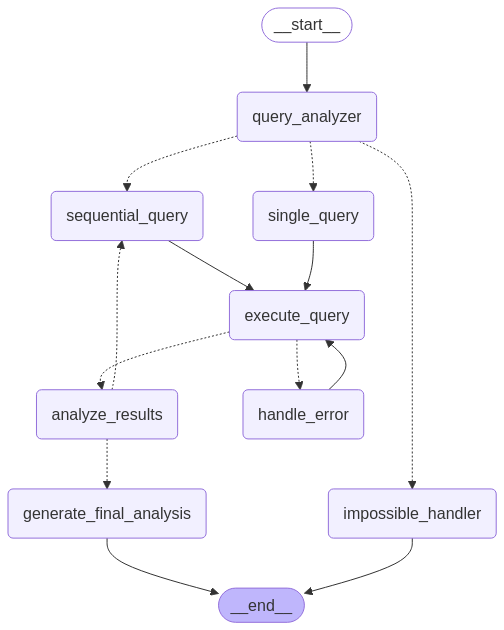

In [ ]:
builder = StateGraph(State)

# 노드 추가
builder.add_node("query_analyzer", query_analyzer)
builder.add_node("sequential_query", sequential_query_handler)
builder.add_node("single_query", single_query_handler)
builder.add_node("execute_query", query_executor)
builder.add_node("analyze_results", result_analyzer)
builder.add_node("handle_error", error_handler)
builder.add_node("generate_final_analysis", final_analysis_generator)
builder.add_node("impossible_handler", impossible_handler)  # 불가능한 질문 처리 노드 추가

# 시작 노드 설정
builder.add_edge(START, "query_analyzer")

# 조건부 엣지 추가 (라우터 함수 사용)
builder.add_conditional_edges(
    "query_analyzer",
    query_analyzer_router,
    {
        "sequential_query": "sequential_query",
        "single_query": "single_query",
        "impossible_handler": "impossible_handler"  # 불가능한 질문 처리 노드로 라우팅
    }
)

# sequential_query와 single_query 모두 execute_query로 연결
builder.add_edge("sequential_query", "execute_query")
builder.add_edge("single_query", "execute_query")

# 불가능한 질문 처리 후 종료
builder.add_edge("impossible_handler", END)

# execute_query의 결과에 따라 다음 노드 결정
builder.add_conditional_edges(
    "execute_query",
    execute_query_router,
    {
        "analyze_results": "analyze_results",
        "handle_error": "handle_error"
    }
)

# handle_error는 항상 execute_query로 돌아감
builder.add_edge("handle_error", "execute_query")

# analyze_results의 결과에 따라 다음 단계 결정
builder.add_conditional_edges(
    "analyze_results",
    analyze_results_router,
    {
        "sequential_query": "sequential_query",
        "generate_final_analysis": "generate_final_analysis"
    }
)

# 최종 분석은 종료
builder.add_edge("generate_final_analysis", END)
graph = builder.compile()
graph


In [ ]:
db_path = "easy_sql.db"
# 데이터베이스 스키마 미리 가져오기
db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
db_schema = db.get_table_info()


test_queries=[
    "가장 많은 매출을 올린 작가의 모든 도서 목록과 재고 현황을 조회해주세요.",
    "IT 분야 도서 목록 알려주세요.",
    "리뷰가 좋은 책들 추천해주세요.",
]

for test_query in test_queries:

    initial_state: State = {
        "messages": [HumanMessage(test_query)],
        "current_query": "",
        "query_results": [],
        "db_path": db_path,
        "query_history": [],
        "db_schema": db_schema  # 미리 가져온 스키마 정보 설정
    }
    result = graph.invoke(initial_state, {"recursion_limit": 150},
)

    print('기존 질문:', test_query)
    print('최종 분석 결과:', result["final_analysis"])
    print('-------------')


기존 질문: 가장 많은 매출을 올린 작가의 모든 도서 목록과 재고 현황을 조회해주세요.
최종 분석 결과: 
답변: 가장 많은 매출을 올린 작가는 유앱개이며, 해당 작가의 도서 목록은 '모바일 앱 프로그래밍'이고 재고는 18개입니다.

전체 분석 요약: 제공된 쿼리 결과를 분석한 결과, 가장 많은 매출을 올린 작가는 유앱개이며, 해당 작가의 도서는 '모바일 앱 프로그래밍'이고 재고는 18개입니다. 쿼리 1은 가장 높은 매출을 올린 도서의 정보를 제공하고, 쿼리 2는 해당 작가의 다른 도서 목록을 보여줍니다. 하지만 유앱개 작가의 다른 도서 정보는 제공되지 않았습니다. 따라서, 유앱개 작가의 전체 도서 목록을 확인하기 위해서는 추가적인 데이터나 쿼리가 필요합니다. 두 쿼리의 결과가 일관성을 보입니다. 즉, 쿼리 1에서 찾은 가장 많은 매출을 올린 도서의 작가가 쿼리 2에서 찾은 작가와 같습니다. 이는 분석 결과의 신뢰성을 높여줍니다.

주요 인사이트: 1. '모바일 앱 프로그래밍'은 유앱개 작가의 도서 중 가장 높은 매출을 기록했습니다.
2. 유앱개 작가의 다른 도서 정보는 제공되지 않았습니다.
3. 쿼리 1은 전체 도서 중에서 가장 높은 매출을 올린 도서의 정보(도서명, 재고, 작가)를 보여줍니다.
4. 쿼리 2는 가장 높은 매출을 올린 작가의 모든 도서 목록과 재고를 보여줍니다.
-------------
기존 질문: IT 분야 도서 목록 알려주세요.
최종 분석 결과: 
답변: IT 분야 도서 목록은 다음과 같습니다: '인공지능의 기초', '파이썬 프로그래밍', '데이터 분석 입문', '머신러닝 알고리즘', '딥러닝의 이해', '빅데이터 처리', '클라우드 컴퓨팅', '자연어 처리', '컴퓨터 비전', '로봇공학 입문', '강화학습 기초', '블록체인 이해', '알고리즘 문제 해결', '데이터베이스 설계', '게임 프로그래밍', '사물인터넷 기초', '컴퓨터 구조론', '운영체제의 이해', '소프트웨어 공학', '인공지능과 미래', '머신러닝 실전 프로젝트', 

In [ ]:
db_path = "intermediate_sql.db"
# 데이터베이스 스키마 미리 가져오기
db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
db_schema = db.get_table_info()

test_queries=[
    "야간 진료 환자가 많은 상위 3개 진료과에 대해, 야간 근무 간호사가 부족한 곳을 찾고,  해당 부서의 의료진 재배치 계획을 수립하시오.",
    "교수별 가장 많이 처방된 약물 TOP 5.",
    "가장 저렴한 시술 목록"
]

for test_query in test_queries:

    initial_state: State = {
        "messages": [HumanMessage(test_query)],
        "current_query": "",
        "query_results": [],
        "db_path": db_path,
        "query_history": [],
        "db_schema": db_schema  # 미리 가져온 스키마 정보 설정
    }
    result = graph.invoke(initial_state, {"recursion_limit": 150},
)

    print('기존 질문:', test_query)
    print('최종 분석 결과:', result["final_analysis"])
    print('-------------')

기존 질문: 야간 진료 환자가 많은 상위 3개 진료과에 대해, 야간 근무 간호사가 부족한 곳을 찾고,  해당 부서의 의료진 재배치 계획을 수립하시오.
최종 분석 결과: 질문 불가능 이유: 주어진 데이터베이스 스키마로는 야간 진료 환자 수를 정확하게 파악하고, 야간 근무 간호사 수를 비교하여 인력 재배치 계획을 수립하는 것이 불가능합니다. 그 이유는 다음과 같습니다.

1. **야간 진료 환자 수 파악의 어려움:** `medical_records` 테이블에 `visit_date` 정보만 있고 정확한 진료 시간 정보가 없어 야간 시간대에 진료를 받은 환자 수를 특정하기 어렵습니다. 만약 `visit_time`과 같은 필드가 있었다면 특정 시간 이후의 환자 수를 계산할 수 있습니다.
2. **야간 근무 간호사 부족 판단의 어려움:** `nurses` 테이블에 근무 교대(`shift`) 정보는 있지만, 각 교대조의 정확한 근무 시간 정보가 없습니다. 또한, 특정 시간대에 필요한 간호사 수에 대한 기준이나 정보가 없어 간호사 부족 여부를 판단하기 어렵습니다. `staff_schedules` 테이블에 근무 날짜, 시작 시간, 종료 시간 정보가 있지만, 이를 활용하여 특정 부서에 야간 근무 간호사가 충분한지 판단하기는 어렵습니다.
3. **의료진 재배치 계획 수립의 불가능:** 데이터베이스는 저장된 데이터를 기반으로 쿼리를 수행하고 결과를 반환하는 데 특화되어 있습니다. 데이터 분석을 통해 특정 부서의 인력 부족을 확인할 수는 있지만, 이를 바탕으로 최적의 재배치 계획을 '수립'하는 것은 데이터베이스의 기능 범위를 벗어납니다. 재배치 계획은 다양한 제약 조건과 목표를 고려하는 복잡한 의사 결정 과정이며, 이는 별도의 분석 도구나 알고리즘을 통해 수행해야 합니다.

따라서, 현재 데이터베이스 스키마로는 원래 질문에 대한 답변을 제공할 수 없습니다.

제안: 대체 질문으로는 다음과 같은 것들을 고려해 볼 수 있습니다.

1.  특정 진료과의 환자 수와 의사 수를 비교하여 의사

In [ ]:
db_path = "intermediate_sql.db"
# 데이터베이스 스키마 미리 가져오기
db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
db_schema = db.get_table_info()

test_queries=[
    "각 진료과별 환자 수를 계산하고, 환자 수가 많은 상위 3개 진료과를 찾으시오."
]

for test_query in test_queries:

    initial_state: State = {
        "messages": [HumanMessage(test_query)],
        "current_query": "",
        "query_results": [],
        "db_path": db_path,
        "query_history": [],
        "db_schema": db_schema  # 미리 가져온 스키마 정보 설정
    }
    result = graph.invoke(initial_state, {"recursion_limit": 150},
)

    print('기존 질문:', test_query)
    print('최종 분석 결과:', result["final_analysis"])
    print('-------------')

기존 질문: 각 진료과별 환자 수를 계산하고, 환자 수가 많은 상위 3개 진료과를 찾으시오.
최종 분석 결과: 
답변: 환자 수가 많은 상위 3개 진료과는 피부과, 정형외과, 소아과이며, 각 진료과의 환자 수는 3명입니다.

전체 분석 요약: 제공된 쿼리 결과에 따르면, 피부과, 정형외과, 소아과가 각각 3명의 환자 수로 상위 3개 진료과에 해당합니다. 환자 수가 동일하여 특정 진료과에 환자가 집중되지 않은 것으로 보입니다. 쿼리 결과는 원래 질문에 대한 답변을 제공하며, 환자 수 기준 상위 진료과를 명확히 제시합니다. 추가적으로, 환자 수 외 다른 요인(예: 각 환자의 내원 횟수, 진료 시간 등)을 고려하면 더 심층적인 분석이 가능할 것입니다.

주요 인사이트: 1. 상위 3개 진료과의 환자 수가 동일합니다. 2. 피부과, 정형외과, 소아과가 환자 수 기준 상위 진료과에 해당합니다. 3. 환자 수 기준으로 볼 때, 특정 진료과에 환자가 집중되지 않고 분산되어 있습니다.
-------------


In [ ]:
from rich import print as rprint
rprint(result)

{
    'messages': [
        HumanMessage(
            content='각 진료과별 환자 수를 계산하고, 환자 수가 많은 상위 3개 진료과를 찾으시오.',
            additional_kwargs={},
            response_metadata={},
            id='e07c388b-3da9-48a0-bcb3-ecb9ba34fd26'
        ),
        AIMessage(
            content='분석 결과: 환자 수는 patients 테이블에 있고, 진료과는 medical_records 테이블의 doctor_id를 
통해 doctors 테이블의 dept_id를 참조하여 departments 테이블에서 얻을 수 있습니다. 따라서, medical_records, doctors,
departments 테이블을 조인하여 각 진료과별 환자 수를 계산하고, 그 결과를 환자 수 기준으로 내림차순 정렬하여 상위 
3개를 선택하는 단일 쿼리로 해결할 수 있습니다.\n단계 수: 1',
            additional_kwargs={},
            response_metadata={},
            id='d03b08eb-3571-4e9c-937d-85818a176a43'
        ),
        AIMessage(
            content="결과 분석: 현재까지의 쿼리 결과는 각 진료과별 환자 수를 계산하고 환자 수가 많은 상위 3개 
진료과를 찾으라는 원래 질문에 대한 답을 제공합니다. 쿼리 1은 'medical_records', 'doctors', 'departments' 테이블을 
조인하여 각 진료과별 환자 수를 계산하고, 환자 수 기준으로 내림차순 정렬하여 상위 3개를 보여줍니다. 현재 결과는 
피부과, 정형외과, 소아과가 각각 3명의 환자 수로 동일하게 상위 3개 진료과로 나타났습니다. 모든 필요한 정보가 
수집되었으므로 분석을 완료합니다.",
            additional_kwargs={},
            response_metadata={},
            id='4063f457-29e2-4591-985e-aa7372663521'
        )
    ],
    'current_query': 'SELECT d.dept_name AS 진료과, COUNT(DISTINCT mr.patient_id) AS 환자수 FROM medical_records mr
JOIN doctors dr ON mr.doctor_id = dr.doctor_id JOIN departments d ON dr.dept_id = d.dept_id GROUP BY d.dept_name 
ORDER BY 환자수 DESC LIMIT 3',
    'query_results': [
        [
            {'진료과': '피부과', '환자수': 3},
            {'진료과': '정형외과', '환자수': 3},
            {'진료과': '소아과', '환자수': 3}
        ]
    ],
    'db_path': 'intermediate_sql.db',
    'query_history': [
        'SELECT d.dept_name AS 진료과, COUNT(DISTINCT mr.patient_id) AS 환자수 FROM medical_records mr JOIN doctors
dr ON mr.doctor_id = dr.doctor_id JOIN departments d ON dr.dept_id = d.dept_id GROUP BY d.dept_name ORDER BY 환자수
DESC LIMIT 3'
    ],
    'error_message': None,
    'final_analysis': '\n답변: 환자 수가 많은 상위 3개 진료과는 피부과, 정형외과, 소아과이며, 각 진료과의 환자 수는
3명입니다.\n\n전체 분석 요약: 제공된 쿼리 결과에 따르면, 피부과, 정형외과, 소아과가 각각 3명의 환자 수로 상위 3개 
진료과에 해당합니다. 환자 수가 동일하여 특정 진료과에 환자가 집중되지 않은 것으로 보입니다. 쿼리 결과는 원래 질문에
대한 답변을 제공하며, 환자 수 기준 상위 진료과를 명확히 제시합니다. 추가적으로, 환자 수 외 다른 요인(예: 각 환자의 
내원 횟수, 진료 시간 등)을 고려하면 더 심층적인 분석이 가능할 것입니다.\n\n주요 인사이트: 1. 상위 3개 진료과의 환자
수가 동일합니다. 2. 피부과, 정형외과, 소아과가 환자 수 기준 상위 진료과에 해당합니다. 3. 환자 수 기준으로 볼 때, 
특정 진료과에 환자가 집중되지 않고 분산되어 있습니다.',
    'next_step': 'generate_final_analysis',
    'db_schema': '\nCREATE TABLE billing (\n\tbill_id INTEGER, \n\tpatient_id INTEGER, \n\trecord_id INTEGER, 
\n\tamount INTEGER NOT NULL, \n\tpayment_status TEXT NOT NULL, \n\tbill_date TEXT NOT NULL, \n\tPRIMARY KEY 
(bill_id), \n\tFOREIGN KEY(patient_id) REFERENCES patients (patient_id), \n\tFOREIGN KEY(record_id) REFERENCES 
medical_records (record_id)\n)\n\n/*\n3 rows from billing 
table:\nbill_id\tpatient_id\trecord_id\tamount\tpayment_status\tbill_date\n1\t1\t1\t50000\t완료\t2024-03-01\n2\t2\t
2\t70000\t완료\t2024-03-02\n3\t3\t3\t1500000\t진행중\t2024-03-03\n*/\n\n\nCREATE TABLE departments (\n\tdept_id 
INTEGER, \n\tdept_name TEXT NOT NULL, \n\tlocation TEXT NOT NULL, \n\tPRIMARY KEY (dept_id)\n)\n\n/*\n3 rows from 
departments table:\ndept_id\tdept_name\tlocation\n1\t내과\t본관 3층\n2\t외과\t본관 4층\n3\t소아과\t별관 
2층\n*/\n\n\nCREATE TABLE doctors (\n\tdoctor_id INTEGER, \n\tdept_id INTEGER, \n\tname TEXT NOT NULL, 
\n\tspecialization TEXT NOT NULL, \n\tphone TEXT NOT NULL, \n\temail TEXT, \n\tPRIMARY KEY (doctor_id), \n\tFOREIGN
KEY(dept_id) REFERENCES departments (dept_id), \n\tUNIQUE (email)\n)\n\n/*\n3 rows from doctors 
table:\ndoctor_id\tdept_id\tname\tspecialization\tphone\temail\n1\t1\t김민준\t소화기내과\t010-1111-2222\tkim@hospit
al.com\n2\t1\t이서연\t호흡기내과\t010-2222-3333\tlee@hospital.com\n3\t2\t박지훈\t일반외과\t010-3333-4444\tpark@hosp
ital.com\n*/\n\n\nCREATE TABLE hospitalizations (\n\thospitalization_id INTEGER, \n\tpatient_id INTEGER, 
\n\troom_number TEXT NOT NULL, \n\tadmission_date TEXT NOT NULL, \n\tdischarge_date TEXT, \n\tPRIMARY KEY 
(hospitalization_id), \n\tFOREI

In [ ]:
db_path = "hard_sql.db"
# 데이터베이스 스키마 미리 가져오기
db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
db_schema = db.get_table_info()

test_queries=[
    "학과별 등록 학생 수와 평균 학점.",
    "장학금 수혜 현황",
    "오늘 졸업하는 사람 얼마야?"
]

for test_query in test_queries:

    initial_state: State = {
        "messages": [HumanMessage(test_query)],
        "current_query": "",
        "query_results": [],
        "db_path": db_path,
        "query_history": [],
        "db_schema": db_schema  # 미리 가져온 스키마 정보 설정
    }
    result = graph.invoke(initial_state, {"recursion_limit": 150},
)

    print('기존 질문:', test_query)
    print('최종 분석 결과:', result["final_analysis"])
    print('-------------')


기존 질문: 학과별 등록 학생 수와 평균 학점.
최종 분석 결과: 질문 불가능 이유: 요청하신 '학과별 등록 학생 수와 평균 학점'을 계산하는 것은 현재 데이터베이스 스키마로는 불가능합니다. 학생 수는 students 테이블과 departments 테이블을 연결하여 구할 수 있지만, 학생들의 평균 학점 정보가 데이터베이스에 저장되어 있지 않기 때문입니다. enrollments 테이블에 grade 정보가 있지만, 이는 특정 강의에 대한 학점일 뿐, 학생 개인의 전체 평균 학점을 나타내지는 않습니다.

제안: 대신, 다음과 같은 질문을 고려해 볼 수 있습니다.

1.  **학과별 등록 학생 수:** 각 학과에 등록된 학생 수를 확인할 수 있습니다.
2.  **강의별 평균 학점:** 특정 강의에 등록한 학생들의 평균 학점을 확인할 수 있습니다.
3.  **학생별 이수 학점:** 학생별로 이수한 총 학점 수를 확인할 수 있습니다.

만약 학생들의 평균 학점을 알고 싶다면, 학생 테이블에 평균 학점 속성을 추가하거나, enrollments 테이블에 각 학생의 전체 평균 학점을 계산하여 저장하는 방안을 고려해야 합니다. 아니면, 학생들의 성적 증명서와 같은 외부 데이터를 활용해야 합니다. 현재 데이터로는 학과별 등록 학생 수를 파악하는 것만 가능합니다. 예를 들어, '컴퓨터공학과 학생은 몇 명인가?' 와 같은 질문은 해결할 수 있습니다. 혹은, '각 학과별 교수의 수는 몇 명인가?' 와 같은 질문도 가능합니다.
-------------
기존 질문: 장학금 수혜 현황
최종 분석 결과: 
답변: 장학금 수혜 현황은 다음과 같습니다: 배영어 학생은 스포츠장학금, 조음악 학생은 예술장학금, 송AI 학생은 봉사장학금, 남영문 학생은 외국어우수장학금을 수혜받았습니다.

전체 분석 요약: 학생별 장학금 수혜 내역을 분석한 결과, 각 학생은 특정 분야의 장학금을 수혜받았습니다. 배영어 학생은 스포츠, 조음악 학생은 예술, 송AI 학생은 봉사, 남영문 학생은 외국어 분야에서 장학금을 받